In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torch.utils.data import DataLoader
from torchvision.models import resnet18
import torchvision.models as models
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
import torchvision.transforms.functional as F
import numpy as np
import matplotlib.pyplot as plt 
import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2
from sklearn.metrics import classification_report,accuracy_score,confusion_matrix

In [3]:
# Set the device for training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
train_path = '/kaggle/input/brain-tumor-mri-dataset/Training'
test_path = '/kaggle/input/brain-tumor-mri-dataset/Testing'

In [5]:
class CustomImageDataset(ImageFolder):
    def __getitem__(self, index):
        path, label = self.samples[index]
        image = self.loader(path)
        
        # Apply the Albumentations transform
        image = np.array(image)  # Convert to numpy array
        if self.transform is not None:
            image = self.transform(image=image)['image']
        
        return image, label

In [6]:
data_transforms = A.Compose([
    A.Resize(224, 224),
    #A.CLAHE(),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

In [7]:
train_dataset = CustomImageDataset(train_path, transform=data_transforms)
train_loader = DataLoader(train_dataset, batch_size = 16, shuffle=True)

val_dataset = CustomImageDataset(test_path, transform=data_transforms)
val_loader = DataLoader(val_dataset, batch_size = 16, shuffle=False)

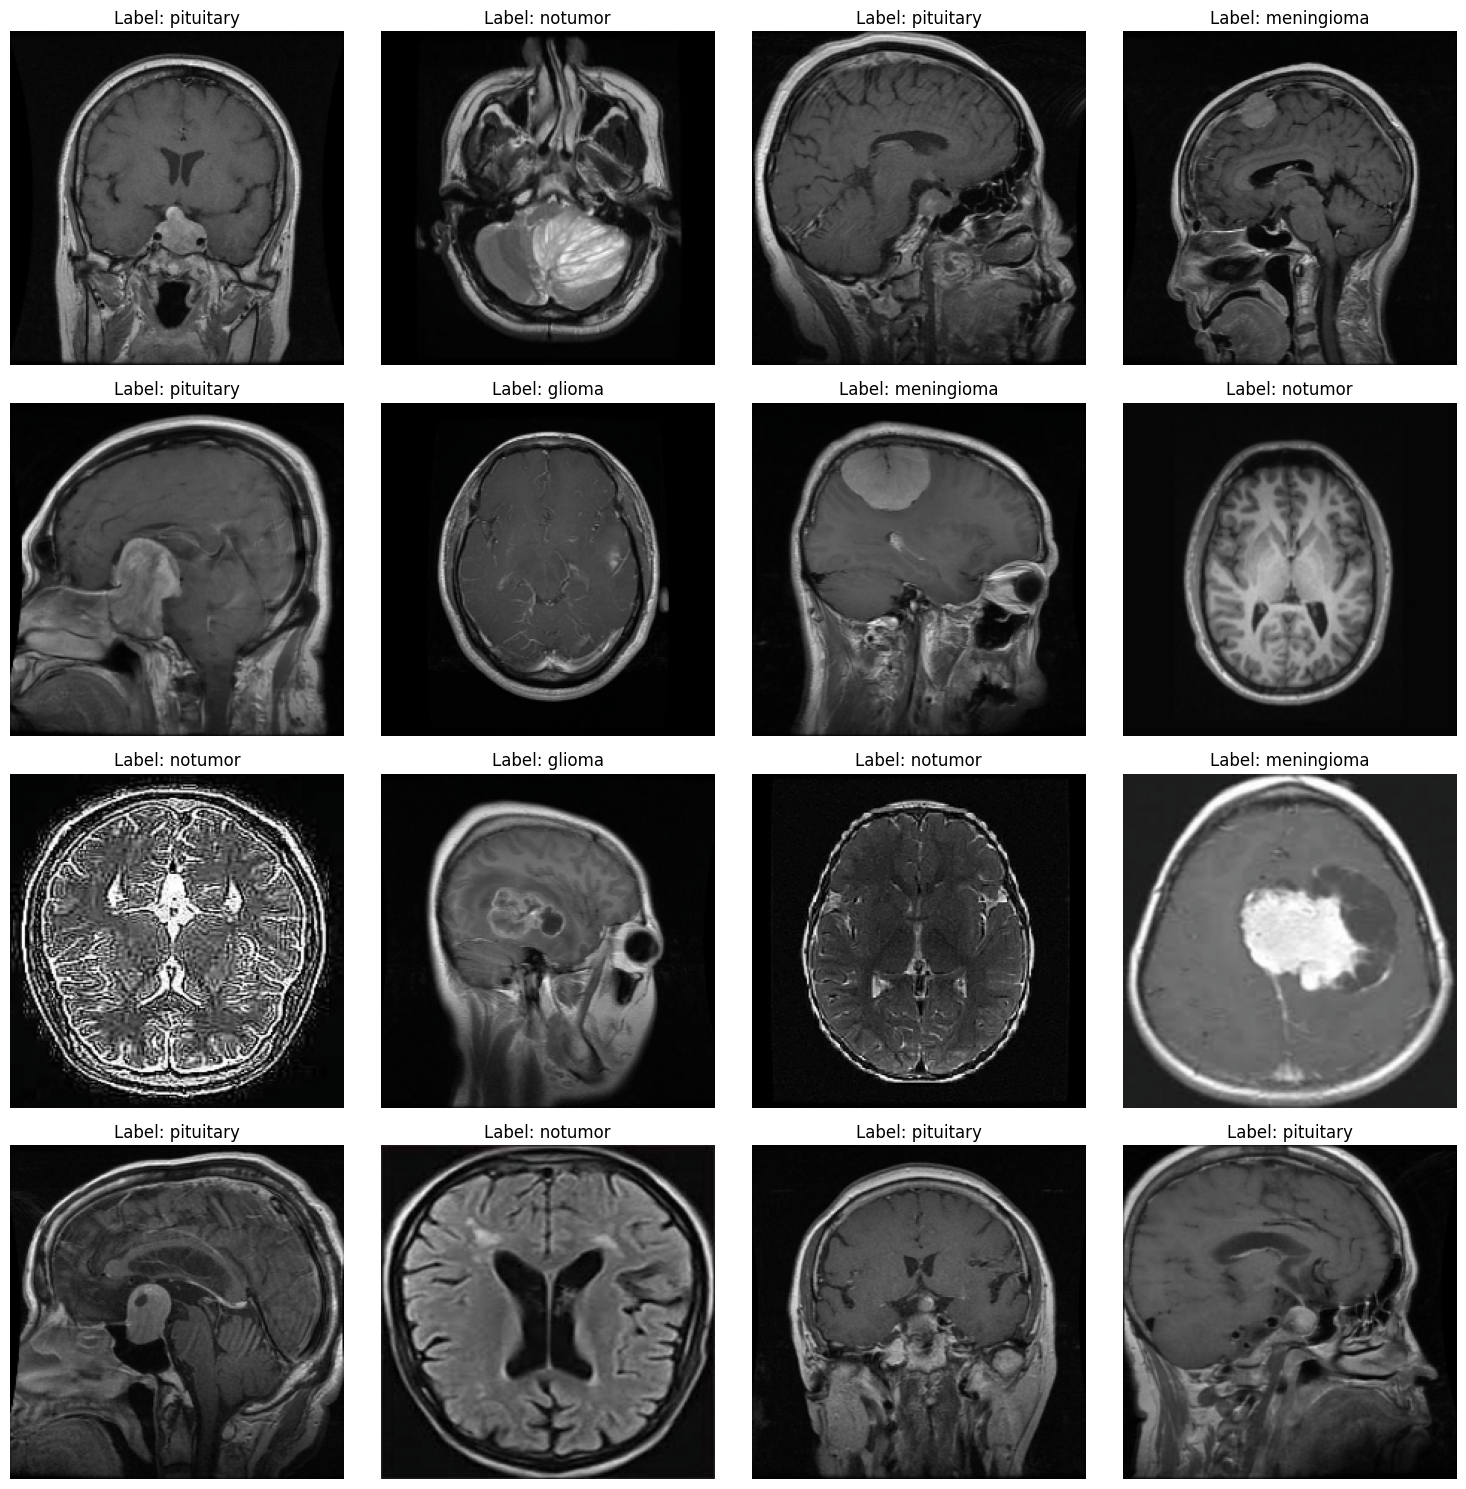

In [22]:
# Load a batch of images and labels for visualization
data_iter = iter(train_loader)
images, labels = next(data_iter)

# Convert images to numpy arrays and denormalize
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
images = (images.numpy().transpose((0, 2, 3, 1)) * std + mean).clip(0, 1)

# Create a grid of images
num_images = len(images)
rows = int(np.ceil(num_images / 4))
fig, axes = plt.subplots(rows, 4, figsize=(15, 15))

# Plot images with labels
for i, ax in enumerate(axes.flat):
    if i < num_images:
        ax.imshow(images[i])
        ax.set_title(f'Label: {train_dataset.classes[labels[i]]}')
    ax.axis('off')

plt.tight_layout()
plt.show()

# Extract Features using ViT and swin

In [8]:
def base_extract(model):
    childs = []
    for child in model.children():
        childs.append(child)
    childs = childs[:-1]
    return nn.Sequential(*childs)

In [24]:
model = models.vit_b_16(weights='DEFAULT')
model.heads = nn.Identity()
vitb16 = model.to(device)

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:01<00:00, 212MB/s]  


In [9]:
model = models.swin_v2_b(weights='DEFAULT')
swinv2B = base_extract(model).to(device)

Downloading: "https://download.pytorch.org/models/swin_v2_b-781e5279.pth" to /root/.cache/torch/hub/checkpoints/swin_v2_b-781e5279.pth
100%|██████████| 336M/336M [00:01<00:00, 212MB/s] 


In [10]:
model = models.swin_v2_s(weights='DEFAULT')
#model.head = nn.Identity()
swinv2S = base_extract(model).to(device)

Downloading: "https://download.pytorch.org/models/swin_v2_s-637d8ceb.pth" to /root/.cache/torch/hub/checkpoints/swin_v2_s-637d8ceb.pth
100%|██████████| 191M/191M [00:00<00:00, 203MB/s] 


In [11]:
model = models.swin_v2_t(weights='DEFAULT')
#model.head = nn.Identity()
swinv2T = base_extract(model).to(device)

Downloading: "https://download.pytorch.org/models/swin_v2_t-b137f0e2.pth" to /root/.cache/torch/hub/checkpoints/swin_v2_t-b137f0e2.pth
100%|██████████| 109M/109M [00:00<00:00, 214MB/s] 


In [12]:
def feature_extraction(model,data):
    model.eval()
    features = []
    labels = []
    for X,y in data:
        with torch.no_grad():
            feature = model(X.to(device))
            features.append(feature.cpu().detach().numpy())
            labels.append(y.cpu().detach().numpy())
    return np.concatenate(features,axis=0),np.concatenate(labels,axis=0)

In [12]:
def feature_extraction1(model2,model3,model4, data):
    #model1.eval()
    model2.eval()
    model3.eval()
    model4.eval()
    features = []
    labels = []
    for X,y in data:
        with torch.no_grad():
            #xV = model1(X.to(device))
            xB = model2(X.to(device))
            xS = model3(X.to(device))
            xT = model4(X.to(device))
            feature = torch.cat([xB,xS,xT],axis=1)
            #feature = model1(X.to(device))
            features.append(feature.cpu().detach().numpy())
            labels.append(y.cpu().detach().numpy())
    return np.concatenate(features,axis=0),np.concatenate(labels,axis=0)

In [13]:
X_train, y_train = feature_extraction1(swinv2B,swinv2S,swinv2T,train_loader)
#XB,_ = feature_extraction(swinv2B,train_loader)
#XS,_ = feature_extraction(swinv2S,train_loader)
#XT,_ = feature_extraction(swinv2T,train_loader)

In [14]:
#X_train = np.concatenate((XV,XB,XS,XT),axis=1)

In [15]:
X_test, y_test = feature_extraction1(swinv2B,swinv2S,swinv2T,val_loader)
#XB,_ = feature_extraction(swinv2B,val_loader)
#XS,_ = feature_extraction(swinv2S,val_loader)
#XT,_ = feature_extraction(swinv2T,val_loader)

In [17]:
#X_test = XT

In [100]:
#X_test = np.concatenate((XV,XB,XS,XT),axis=1)

# Machine Learning Model

In [26]:
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

In [32]:
svm = SVC(probability=True)
svm.fit(X_train, y_train)

pred = svm.predict(X_train)
print(classification_report(y_train, pred))

              precision    recall  f1-score   support

           0       1.00      0.95      0.97      1321
           1       0.93      0.98      0.95      1339
           2       0.99      1.00      0.99      1595
           3       0.99      0.99      0.99      1457

    accuracy                           0.98      5712
   macro avg       0.98      0.98      0.98      5712
weighted avg       0.98      0.98      0.98      5712



In [33]:
svm_pred = svm.predict(X_test)
print(classification_report(y_test, svm_pred))

              precision    recall  f1-score   support

           0       0.99      0.85      0.92       300
           1       0.85      0.95      0.90       306
           2       0.98      1.00      0.99       405
           3       0.99      0.98      0.98       300

    accuracy                           0.95      1311
   macro avg       0.95      0.95      0.95      1311
weighted avg       0.95      0.95      0.95      1311



In [34]:
accuracy_score(y_test,svm_pred)

0.9496567505720824

In [35]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

pred = knn.predict(X_train)
print(classification_report(y_train, pred))

              precision    recall  f1-score   support

           0       0.99      0.95      0.97      1321
           1       0.93      0.95      0.94      1339
           2       0.98      0.98      0.98      1595
           3       0.98      0.99      0.99      1457

    accuracy                           0.97      5712
   macro avg       0.97      0.97      0.97      5712
weighted avg       0.97      0.97      0.97      5712



In [36]:
knn_pred = knn.predict(X_test)
print(classification_report(y_test, knn_pred))

              precision    recall  f1-score   support

           0       0.97      0.88      0.92       300
           1       0.87      0.86      0.86       306
           2       0.94      0.99      0.96       405
           3       0.95      0.99      0.97       300

    accuracy                           0.93      1311
   macro avg       0.93      0.93      0.93      1311
weighted avg       0.93      0.93      0.93      1311



In [37]:
accuracy_score(y_test,knn_pred)

0.9328756674294432

In [38]:
lr = LogisticRegression(dual=False,max_iter=1000,random_state=2014,tol=0.0001)

In [39]:
lr.fit(X_train, y_train)

pred = lr.predict(X_train)
print(classification_report(y_train, pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1321
           1       1.00      1.00      1.00      1339
           2       1.00      1.00      1.00      1595
           3       1.00      1.00      1.00      1457

    accuracy                           1.00      5712
   macro avg       1.00      1.00      1.00      5712
weighted avg       1.00      1.00      1.00      5712



In [40]:
lr_pred = lr.predict(X_test)
print(classification_report(y_test, lr_pred))

              precision    recall  f1-score   support

           0       0.99      0.93      0.96       300
           1       0.93      0.97      0.95       306
           2       1.00      1.00      1.00       405
           3       0.99      0.99      0.99       300

    accuracy                           0.98      1311
   macro avg       0.98      0.98      0.98      1311
weighted avg       0.98      0.98      0.98      1311



In [41]:
accuracy_score(y_test,lr_pred)

0.977116704805492

In [25]:
from sklearn.ensemble import VotingClassifier

In [43]:
svm = SVC(probability=True)
lr = LogisticRegression(dual=False,max_iter=1000,random_state=2014,tol=0.0001)
knn = KNeighborsClassifier()

In [44]:
ensem = VotingClassifier(estimators=[('clf1',svm),('clf2',lr),('clf3',knn)],voting='soft',weights=[1,2,1])

In [45]:
ensem = ensem.fit(X_train,y_train)

In [46]:
pred = ensem.predict(X_train)

In [47]:
print(classification_report(y_train, pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1321
           1       1.00      1.00      1.00      1339
           2       1.00      1.00      1.00      1595
           3       1.00      1.00      1.00      1457

    accuracy                           1.00      5712
   macro avg       1.00      1.00      1.00      5712
weighted avg       1.00      1.00      1.00      5712



In [48]:
accuracy_score(y_train,pred)

0.9996498599439776

In [49]:
y_pred = ensem.predict(X_test)

In [50]:
accuracy_score(y_test,y_pred)

0.9763539282990084

In [51]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.93      0.96       300
           1       0.93      0.97      0.95       306
           2       1.00      1.00      1.00       405
           3       0.99      1.00      0.99       300

    accuracy                           0.98      1311
   macro avg       0.98      0.97      0.97      1311
weighted avg       0.98      0.98      0.98      1311



In [52]:
import seaborn as sns

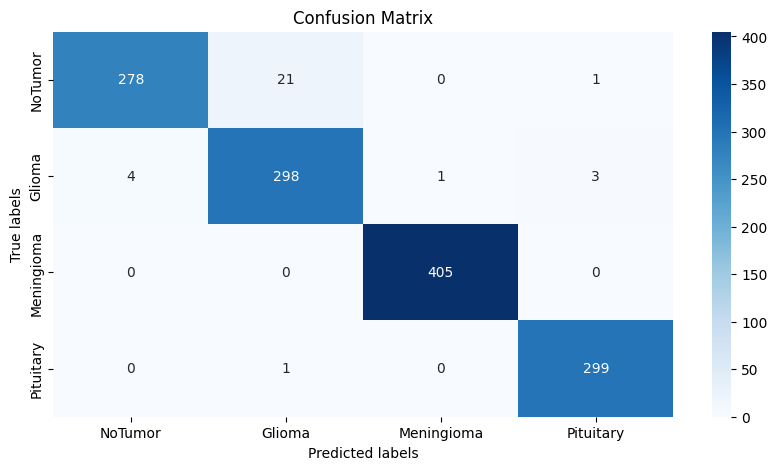

In [53]:
cf = confusion_matrix(y_test,y_pred)
plt.figure(figsize=(10,5))

ax= plt.subplot()
sns.heatmap(cf, annot=True, fmt='d', ax=ax,cmap="Blues");  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['NoTumor','Glioma','Meningioma','Pituitary'])
ax.yaxis.set_ticklabels(['NoTumor','Glioma','Meningioma','Pituitary'])
plt.savefig('/kaggle/working/ensemWithoutPostCF.jpg',dpi=300)

# Feature Reduction

In [16]:
 cols = []

In [17]:
for col in range(X_train.shape[1]):
    if X_train[:,col].var()<0.001:
        cols.append(col)

In [18]:
def find_correlation(X):
    correlation = np.corrcoef(X)
    correlated_feature = []
    for i in range(X.shape[1]):
        for j in range(i+1,X.shape[1]):
            if np.abs(correlation[i][j])>0.90:
                correlated_feature.append(i)
    return correlated_feature

In [19]:
correlated_features = find_correlation(X_train)

In [20]:
cols = cols + correlated_features

In [21]:
cols = np.array(cols)

In [22]:
cols = np.unique(cols)

In [23]:
len(cols)

800

In [27]:
svm = SVC(probability=True)
lr = LogisticRegression(dual=False,max_iter=1000,random_state=2014,tol=0.0001)
knn = KNeighborsClassifier()

In [28]:
newX = np.delete(X_train,cols,axis=1)

In [29]:
svm.fit(newX,y_train)
newY = svm.predict(newX)
print(accuracy_score(y_train,newY))

0.9779411764705882


In [30]:
newXtest = np.delete(X_test,cols,axis=1)

In [31]:
newYpred = svm.predict(newXtest)
print(accuracy_score(y_test,newYpred))

0.9481311975591151


In [32]:
lr.fit(newX,y_train)
newY = lr.predict(newX)
print(accuracy_score(y_train,newY))
newYpred = lr.predict(newXtest)
print(accuracy_score(y_test,newYpred))

1.0
0.9755911517925248


In [33]:
knn.fit(newX,y_train)
newY = knn.predict(newX)
print(accuracy_score(y_train,newY))
newYpred = knn.predict(newXtest)
print(accuracy_score(y_test,newYpred))

0.9672619047619048
0.9290617848970252


In [34]:
svm = SVC(probability=True)
lr = LogisticRegression(dual=False,max_iter=1000,random_state=2014,tol=0.0001)
knn = KNeighborsClassifier()

In [35]:
ensem = VotingClassifier(estimators=[('clf1',svm),('clf2',lr),('clf3',knn)],voting='soft',weights=[1,2,1])

In [36]:
ensem.fit(newX,y_train)
newY = ensem.predict(newX)
print(accuracy_score(y_train,newY))
newYpred = ensem.predict(newXtest)
print(accuracy_score(y_test,newYpred))
print(classification_report(y_test, newYpred))

0.9996498599439776
0.9748283752860412
              precision    recall  f1-score   support

           0       0.99      0.92      0.95       300
           1       0.92      0.98      0.95       306
           2       1.00      1.00      1.00       405
           3       0.99      1.00      0.99       300

    accuracy                           0.97      1311
   macro avg       0.97      0.97      0.97      1311
weighted avg       0.98      0.97      0.97      1311



In [37]:
import seaborn as sns

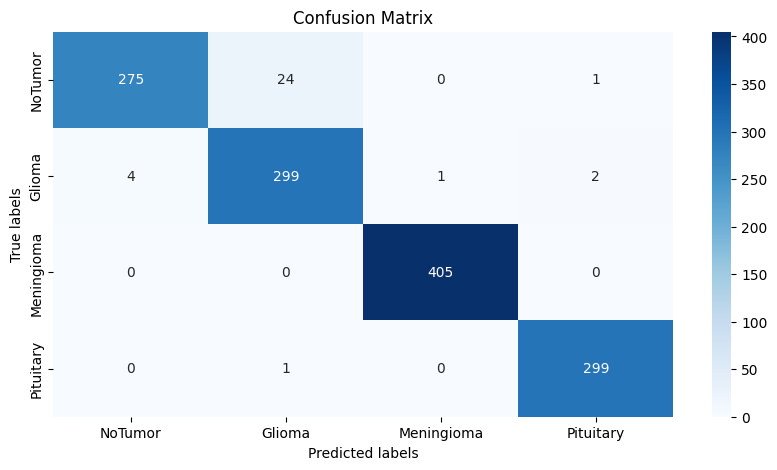

In [38]:
cf = confusion_matrix(y_test,newYpred)
plt.figure(figsize=(10,5))

ax= plt.subplot()
sns.heatmap(cf, annot=True, fmt='d', ax=ax,cmap="Blues");  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['NoTumor','Glioma','Meningioma','Pituitary'])
ax.yaxis.set_ticklabels(['NoTumor','Glioma','Meningioma','Pituitary'])
plt.savefig('/kaggle/working/ensemCF.jpg',dpi=300)

## Visualization

In [74]:
import pandas as pd
import seaborn as sns

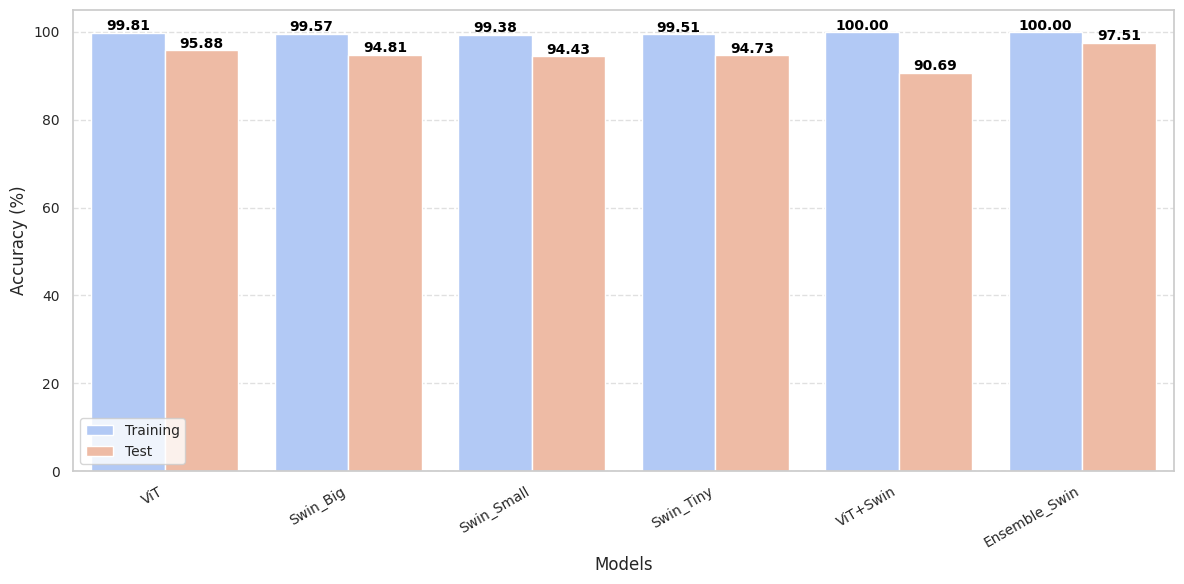

In [75]:

# Data for the visualization
models = ["ViT", "Swin_Big", "Swin_Small", "Swin_Tiny", "ViT+Swin","Ensemble_Swin"]
training_accuracy = [99.81, 99.57, 99.38, 99.51, 100.0, 100.0]
test_accuracy = [95.88, 94.81, 94.43, 94.73, 90.69, 97.51]

# Create a DataFrame for Seaborn
data = pd.DataFrame({
    "Model": models * 2,
    "Accuracy (%)": training_accuracy + test_accuracy,
    "Type": ["Training"] * len(models) + ["Test"] * len(models)
})
# Set the style
sns.set_theme(style="whitegrid")

# Plot the grouped bar chart
plt.figure(figsize=(12, 6))
sns.barplot(
    x="Model", y="Accuracy (%)", hue="Type", data=data,
    palette='coolwarm', saturation=0.8
)
plt.grid(axis='y', linestyle='--', alpha=0.6)
# Add exact values on top of the bars
for i, row in data.iterrows():
    if row["Type"]=="Training":
        plt.text(i % len(models)-0.2, row["Accuracy (%)"] + 0.55, f"{row['Accuracy (%)']:.2f}", 
             ha="center", fontsize=10, color="black", fontweight="bold")
    else:
        plt.text(i % len(models)+0.2, row["Accuracy (%)"] + 0.55, f"{row['Accuracy (%)']:.2f}", 
             ha="center", fontsize=10, color="black", fontweight="bold")

# Titles and labels
plt.xlabel("Models", fontsize=12)
plt.ylabel("Accuracy (%)", fontsize=12)
plt.xticks(rotation=30, ha="right", fontsize=10)
plt.yticks(fontsize=10)

# Add legend
plt.legend(fontsize=10, loc="lower left")

# Adjust layout and show plot
plt.tight_layout()
plt.savefig('modelcom')


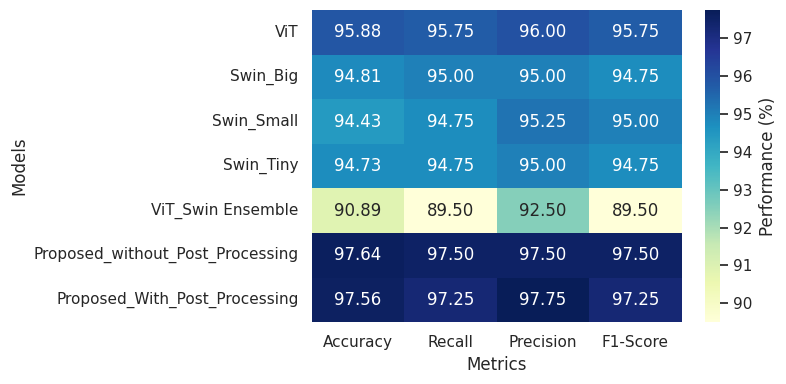

In [76]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Data for Table II: Performance Metrics of Models
models = [
    "ViT",
    "Swin_Big",
    "Swin_Small",
    "Swin_Tiny",
    "ViT_Swin Ensemble",
    "Proposed_without_Post_Processing",
    "Proposed_With_Post_Processing"
]

metrics = ["Accuracy", "Recall", "Precision", "F1-Score"]

# Corresponding metric values
data = np.array([
    [95.88, 95.75, 96.00, 95.75],  # ViT
    [94.81, 95.00, 95.00, 94.75],  # Swin Big
    [94.43, 94.75, 95.25, 95.00],  # Swin Small
    [94.73, 94.75, 95.00, 94.75],  # Swin Tiny
    [90.89, 89.50, 92.50, 89.50],  # ViT Swin Ensemble
    [97.64, 97.50, 97.50, 97.50],  # Proposed (No Post-Processing)
    [97.56, 97.25, 97.75, 97.25]   # Proposed (With Post-Processing)
])

# Create the heatmap
plt.figure(figsize=(8, 4))

sns.heatmap(data, annot=True, fmt=".2f", cmap="YlGnBu", xticklabels=metrics, yticklabels=models, cbar_kws={'label': 'Performance (%)'})

plt.xlabel("Metrics", fontsize=12)
plt.ylabel("Models", fontsize=12)
plt.tight_layout()
plt.savefig('modelmet')


In [40]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    matthews_corrcoef
)

In [41]:
cm = np.array([[275,24,0,1],
     [4,299,1,2],
     [0,0,405,0],
     [0,1,0,299]])

In [44]:
# Confusion Matrix
#cm = confusion_matrix(y_test, newYpred)
classes = ['NoTumor','Glioma','Meningioma','Pituitary']
# Specificity Calculation
specificity = []
for i in range(len(classes)):
    tn = np.sum(np.delete(np.delete(cm, i, axis=0), i, axis=1))  # True negatives
    fp = np.sum(np.delete(cm, i, axis=0)[:, i])                 # False positives
    specificity.append(tn / (tn + fp))

# Dice Coefficient and Jaccard Index
dice = []
jaccard = []
for i in range(len(classes)):
    tp = cm[i, i]
    fn = np.sum(cm[i, :]) - tp
    fp = np.sum(cm[:, i]) - tp
    dice.append(2 * tp / (2 * tp + fp + fn))
    jaccard.append(tp / (tp + fp + fn))

# Matthews Correlation Coefficient (MCC)
mcc = matthews_corrcoef(y_test, newYpred)

# Results
print(f"Specificity: {np.mean(specificity):.3f}")
print(f"Specificity (per class): {[s for s in specificity]}")
print(f"Dice Coefficient (per class): {[d for d in dice]}")
print(f"Jaccard Index (per class): {[j for j in jaccard]}")
print(f"Matthews Correlation Coefficient (MCC): {mcc:.f}")

Specificity: 0.992
Specificity (per class): [0.9960435212660732, 0.9751243781094527, 0.9988962472406181, 0.9970326409495549]
Dice Coefficient (per class): [0.9499136442141624, 0.9492063492063492, 0.998766954377312, 0.9933554817275747]
Jaccard Index (per class): [0.9046052631578947, 0.9033232628398792, 0.9975369458128078, 0.9867986798679867]
Matthews Correlation Coefficient (MCC): 0.97


In [45]:
np.array([0.9046052631578947, 0.9033232628398792, 0.9975369458128078, 0.9867986798679867]).mean()

0.9480660379196421

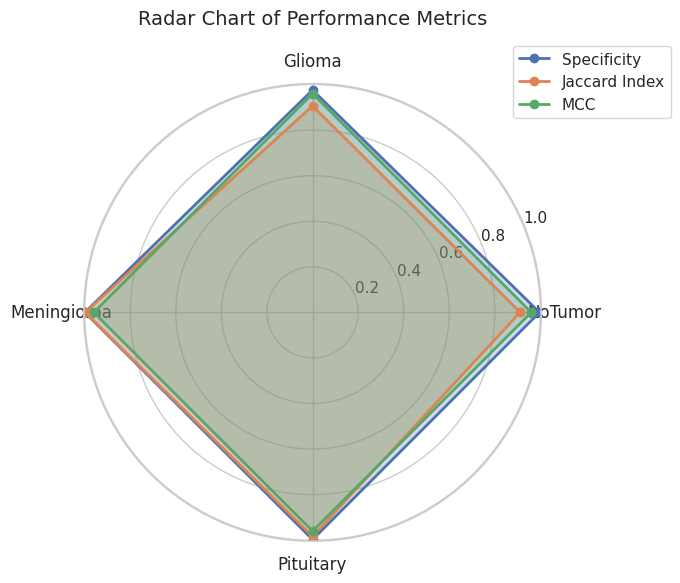

In [86]:
# Data
metrics = ["Specificity", "Dice Coefficient", "Jaccard Index", "MCC"]
classes = ['NoTumor','Glioma','Meningioma','Pituitary']
data = {
    "Specificity": [0.996, 0.976, 0.999, 0.997],
    "Jaccard Index": [0.911, 0.906, 0.998, 0.983],
    "MCC": [0.96, 0.96, 0.96, 0.96],  # MCC is the same for all classes
}

# Prepare data for radar chart
num_classes = len(classes)
angles = np.linspace(0, 2 * np.pi, num_classes, endpoint=False).tolist() + [0]  # Circular layout

fig, ax = plt.subplots(figsize=(8, 6), subplot_kw={"projection": "polar"})

# Plot each metric
for metric, values in data.items():
    values += values[:1]  # Repeat the first value to close the circle
    ax.plot(angles, values, label=metric, linewidth=2, marker="o")
    ax.fill(angles, values, alpha=0.25)

# Add class labels to the chart
ax.set_xticks(angles[:-1])
ax.set_xticklabels(classes, fontsize=12)

# Add title and legend
plt.title("Radar Chart of Performance Metrics", fontsize=14, pad=20)
ax.legend(loc="upper right", bbox_to_anchor=(1.3, 1.1))
plt.tight_layout()
plt.show()


In [43]:
import numpy as np
from sklearn.metrics import confusion_matrix

def calculate_mcc_per_class(y_true, y_pred):
    classes = np.unique(y_true)
    mcc_scores = {}
    
    for cls in classes:
        # Binary classification for the current class
        y_true_binary = (y_true == cls).astype(int)
        y_pred_binary = (y_pred == cls).astype(int)
        
        # Calculate confusion matrix elements
        TN, FP, FN, TP = confusion_matrix(y_true_binary, y_pred_binary).ravel()
        
        # Matthews Correlation Coefficient formula
        numerator = (TP * TN) - (FP * FN)
        denominator = np.sqrt((TP + FP) * (TP + FN) * (TN + FP) * (TN + FN))
        mcc = numerator / denominator if denominator != 0 else 0
        
        # Store MCC for the current class
        mcc_scores[cls] = mcc
    
    return mcc_scores


mcc_scores = calculate_mcc_per_class(y_test, newYpred)
print("MCC per class:", mcc_scores)


MCC per class: {0: 0.9367574444800737, 1: 0.9338196057053184, 2: 0.9982163651515045, 3: 0.9913845301676236}
